# Laboratorio 4 - Inteligencia Computacional
### Árboles de decisión

#### Integrantes: Antonina Arriagada - Francisco Moreno
#### Profesor: Max Chacón - Ayudante: Héctor Rojas-Pescio

In [147]:
# install.packages("C50")
# install.packages("caret")
# install.packages("ggpubr")
# install.packages("factoextra")
# install.packages("devtools")
# install.packages("outliers")

# install.packages("smotefamily")

# 1. Instrucciones previas

Importación de librerías

In [148]:
library ( C50         )
library ( caret       )
library ( ggpubr      )
library ( devtools    )
library ( outliers    )
library ( smotefamily )


library (  factoextra    )
# install_github("vqv/ggbiplot")
library (  ggbiplot      )
library(readr)


In [149]:
library(dplyr)


Lectura del archivo

In [150]:
df <- read_delim("./datasets/ENB2012_data_f.csv", delim = ';')

Rows: 768 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: ";"
dbl (10): X1, X2, X3, X4, X5, X6, X7, X8, Y1, Y2

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [151]:
head( df, 3 )

X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.98,514.5,294,110.25,7,2,0,0,15.55,21.33
0.98,514.5,294,110.25,7,3,0,0,15.55,21.33
0.98,514.5,294,110.25,7,4,0,0,15.55,21.33


In [152]:
# Convertir las columnas a factores
df <- as.data.frame(lapply(df, function(x) {
  if (is.character(x)) as.factor(x) else x
}))

In [153]:
head( df, 3 )

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.98,514.5,294,110.25,7,2,0,0,15.55,21.33
2,0.98,514.5,294,110.25,7,3,0,0,15.55,21.33
3,0.98,514.5,294,110.25,7,4,0,0,15.55,21.33


Revisión de datos perdidos

In [154]:
colSums(is.na(df))

X1 X2 X3 X4 X5 X6 X7 X8 Y1 Y2 
 0  0  0  0  0  0  0  0  0  0

In [155]:
str(df[, c(1:8)])


'data.frame':	768 obs. of  8 variables:
 $ X1: num  0.98 0.98 0.98 0.98 0.9 0.9 0.9 0.9 0.86 0.86 ...
 $ X2: num  514 514 514 514 564 ...
 $ X3: num  294 294 294 294 318 ...
 $ X4: num  110 110 110 110 122 ...
 $ X5: num  7 7 7 7 7 7 7 7 7 7 ...
 $ X6: num  2 3 4 5 2 3 4 5 2 3 ...
 $ X7: num  0 0 0 0 0 0 0 0 0 0 ...
 $ X8: num  0 0 0 0 0 0 0 0 0 0 ...


# 2. Pre-procesamiento del dataset


El tratamiento de datos es una etapa crítica en el análisis de datos y el modelado predictivo. Consiste en la preparación y transformación de datos brutos en un formato adecuado para su análisis. Algunas de las tareas comunes en el tratamiento de datos incluyen:

- Identificación y corrección de errores, valores perdidos y datos atípicos.
- Cambio del formato o tipo de los datos para adecuarlos a los requisitos del análisis. Por ejemplo, convertir factores a variables numéricas.
- Ajuste de las escalas de los datos para asegurar que todas las variables contribuyan equitativamente al análisis.


In [156]:
data_raw <- data.frame(lapply(df, function(x) {
  if (is.factor(x)) as.numeric(as.character(x)) else x
}))
data <- data_raw[, c(1:8)]
sm_pca <- prcomp(data, center=TRUE, scale=TRUE)
summary( sm_pca )

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.9243 1.1135 1.1013 1.0000 0.88715 0.22968 0.06675
Proportion of Variance 0.4629 0.1550 0.1516 0.1250 0.09838 0.00659 0.00056
Cumulative Proportion  0.4629 0.6179 0.7695 0.8945 0.99285 0.99944 1.00000
                             PC8
Standard deviation     4.667e-15
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00

Se establecen rangos para Y1 según cuartiles

In [157]:
min_y1 <- min(data_raw$Y1, na.rm = TRUE)
max_y1 <- max(data_raw$Y1, na.rm = TRUE)

min_y1
max_y1



[1] 6.01

[1] 43.1

In [158]:
n_intervals <- 4

# Crear los intervalos
breaks <- seq(min_y1, max_y1, length.out = n_intervals + 1)
labels <- paste0("Rango ", seq(1, n_intervals))


In [159]:
data_raw$Y1_group <- cut(data_raw$Y1, breaks = breaks, labels = labels, include.lowest = TRUE)
table(data_raw$Y1_group)


Rango 1 Rango 2 Rango 3 Rango 4 
    309     129     210     120 

In [160]:
length(data_raw$Y1_group)

[1] 768

### Gráfico de PCA

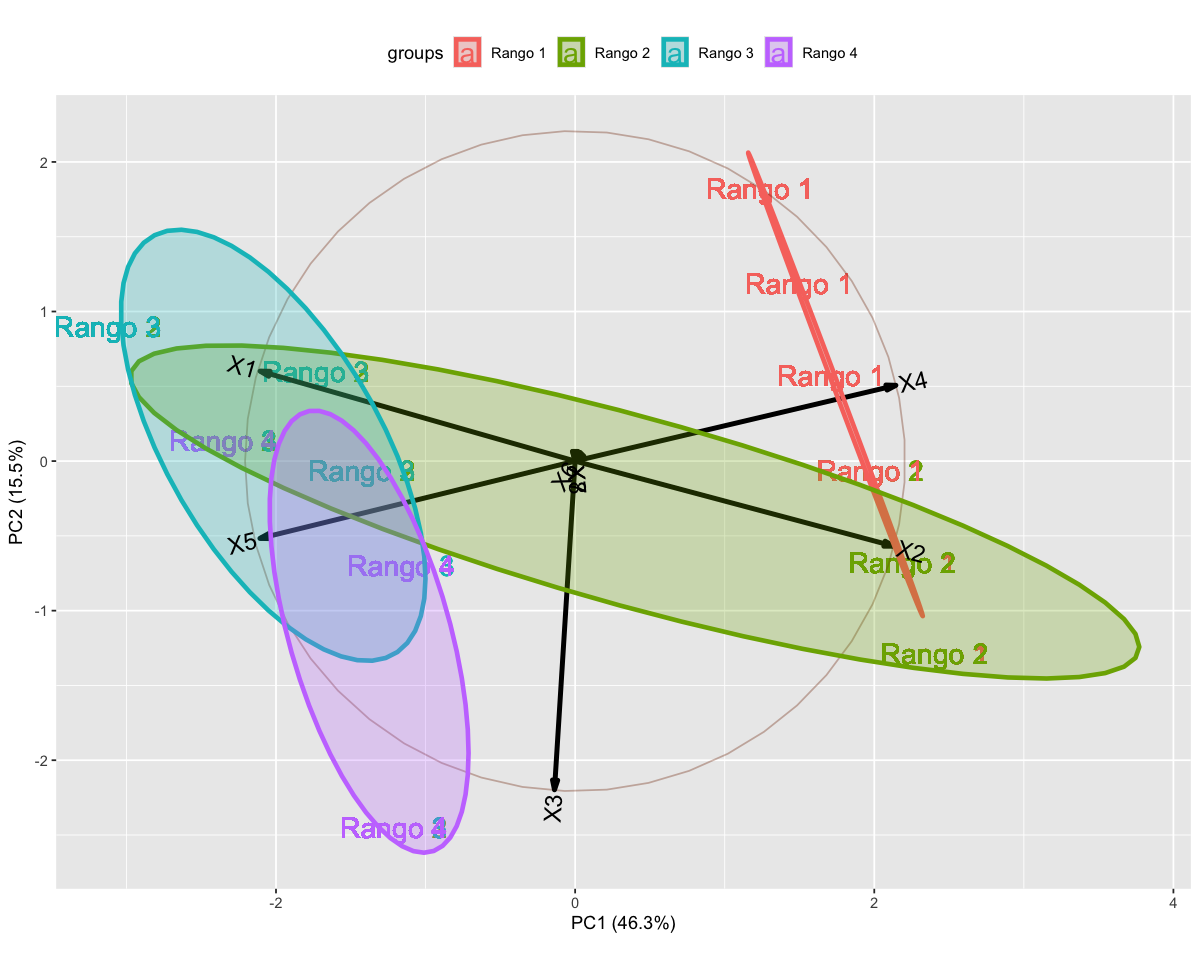

In [161]:
sm_y1 <- as.factor(data_raw$Y1_group)
ggbiplot( sm_pca, ellipse=TRUE, circle=TRUE, labels=sm_y1, groups = sm_y1,
          varname.size=5, labels.size=6, var.scale = 1, obs.scale = 1) +
          theme(legend.direction = 'horizontal', legend.position = 'top')

La proporción de varianza explicada (PEV), del inglés "Proportion Explained of Variance," es una métrica que permite identificar la variable o conjunto de variables que, con la mayor precisión y en el menor número de dimensiones posibles, describe el conjunto original de datos.

In [162]:
pv <- sm_pca$sdev^2 / sum(sm_pca$sdev^2)
pev <- cumsum(pv)
pev

[1] 0.4628674 0.6178488 0.7694694 0.8944694 0.9928488 0.9994431 1.0000000
[8] 1.0000000

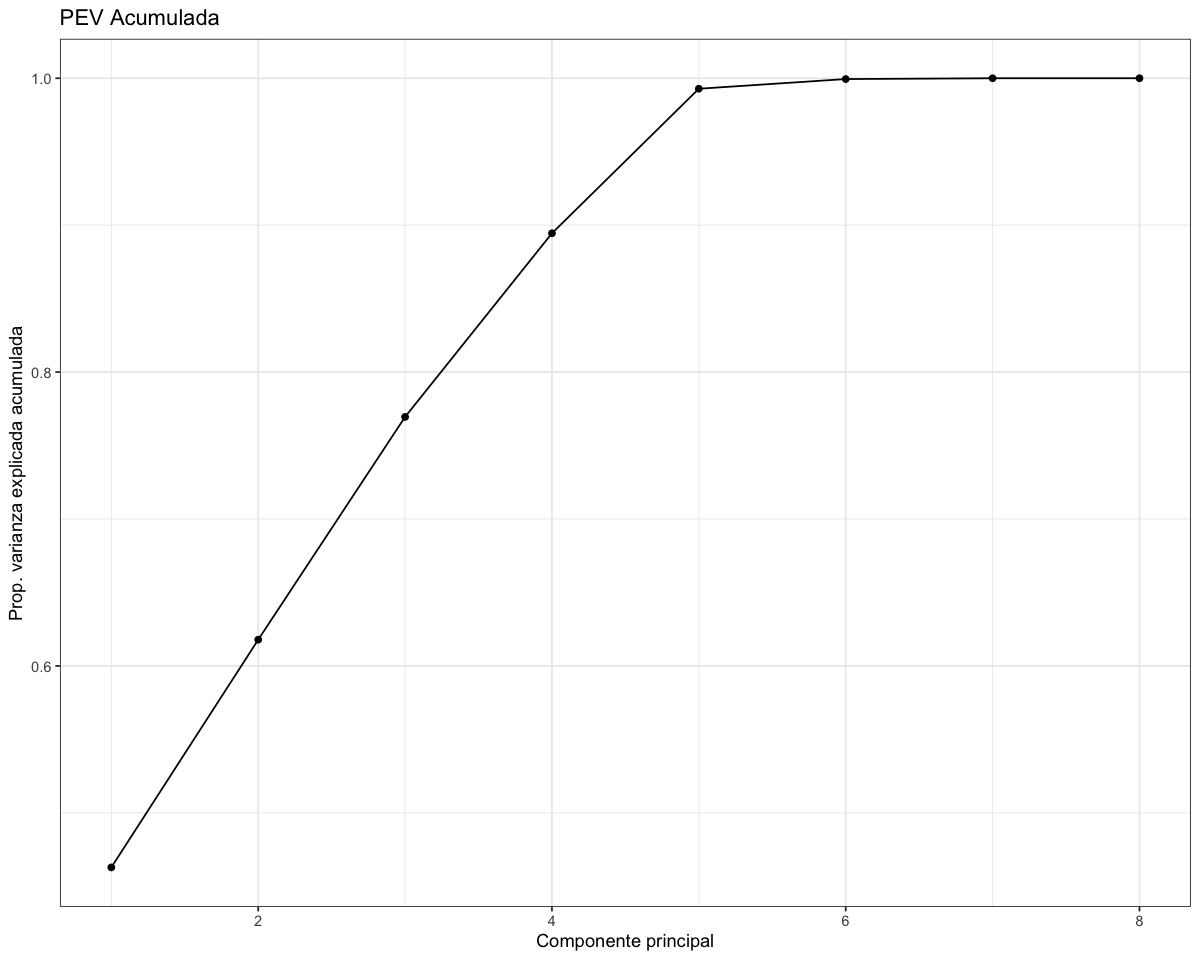

In [163]:
ggplot(data = data.frame(pev, pc = 1:8),
       aes(x = pc, y = pev, group = 1)) +
       geom_point() +
       geom_line() +
       ggtitle("PEV Acumulada")+
       theme_bw() +
       labs(x = "Componente principal",
            y = "Prop. varianza explicada acumulada")

Los resultados muestran que un PEV acumulado del 85% se obtiene utilizando cinco variables. Alternativamente, se podrían emplear cuatro dimensiones que en conjunto explican el 80% de la información original. No obstante, consideramos adecuado utilizar el 5% adicional sobre el 80% para mejorar la precisión en estudios futuros.

### Análisis de variables

El siguiente gráfico permite visualizar las principales variables que contribuyen con información en el PEV acumulado.

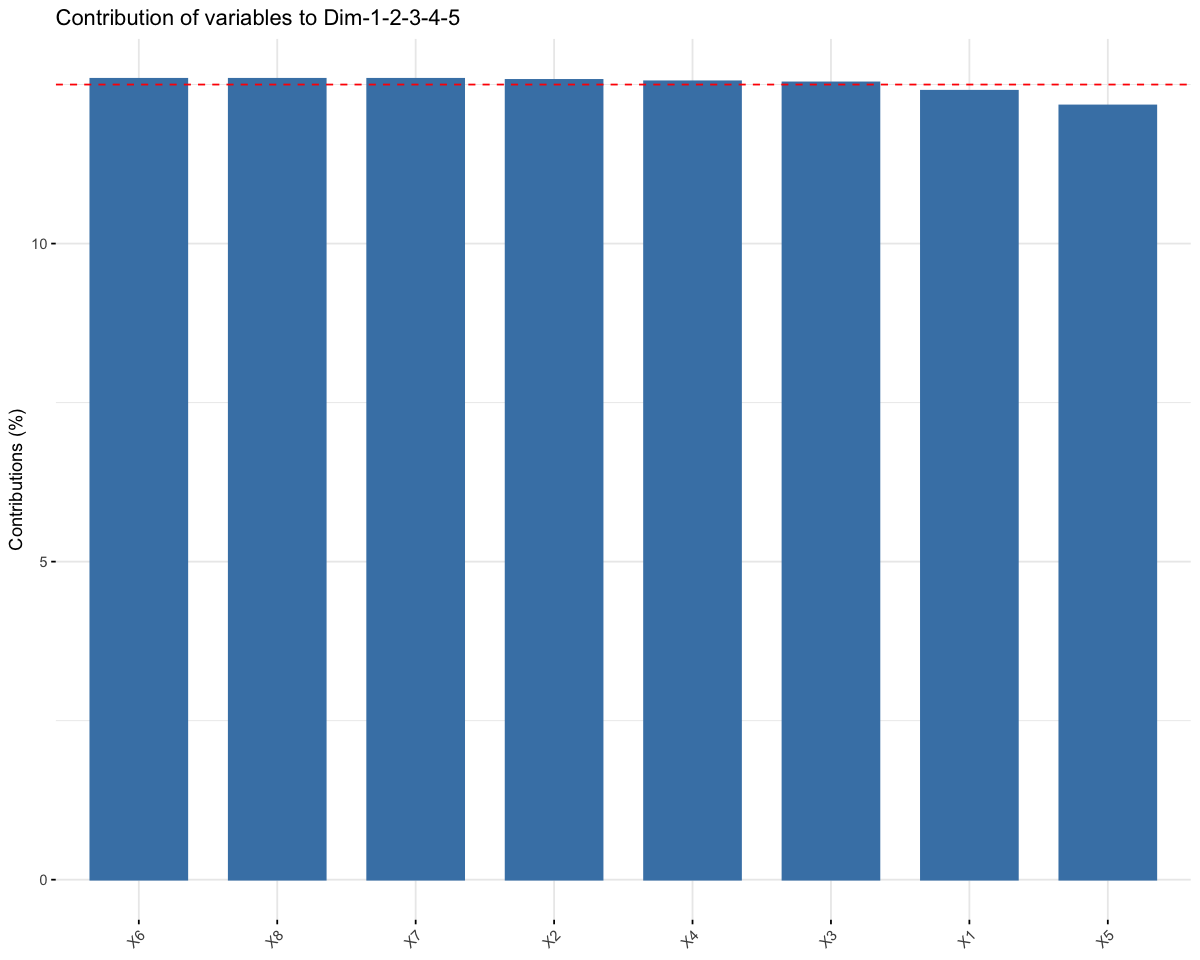

In [164]:
fviz_contrib(sm_pca, choice="var", axes=1:5)


### Reducción de Dimensionalidad

Considerando lo anterior, se reduce la dimensionalidad del conjunto inicial de 10 a 5 variables. Además, se cambia el tipo de dato de la variable de salida Y1, ya que el objetivo del análisis de reglas de asociación es identificar patrones comunes dentro de un mismo grupo. En este contexto, Y2 no será considerada como variable de salida.

In [165]:
drops <- c( "X6", "X7", "X8", "Y1","Y2")
sm_reduced <- data_raw[ , !(names(data_raw) %in% drops)]
sm_reduced$Y1_group <- as.factor( sm_reduced$Y1_group )

head( sm_reduced, 3 )
tail( sm_reduced, 3 )

,X1,X2,X3,X4,X5,Y1_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.98,514.5,294,110.25,7,Rango 2
2,0.98,514.5,294,110.25,7,Rango 2
3,0.98,514.5,294,110.25,7,Rango 2


,X1,X2,X3,X4,X5,Y1_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
766,0.62,808.5,367.5,220.5,3.5,Rango 2
767,0.62,808.5,367.5,220.5,3.5,Rango 2
768,0.62,808.5,367.5,220.5,3.5,Rango 2


### Resumen de datos por clase

In [166]:
levels_y1 <- levels(sm_reduced$Y1_group)

# Resumen de datos
for (level in levels_y1) {
  cat(paste0("=== Resumen de datos para ", level, " ===\n"))
  print(summary(sm_reduced[sm_reduced$Y1_group == level,]))
  cat("\n")
}


=== Resumen de datos para Rango 1 ===
       X1               X2              X3              X4              X5     
 Min.   :0.6200   Min.   :686.0   Min.   :245.0   Min.   :220.5   Min.   :3.5  
 1st Qu.:0.6600   1st Qu.:710.5   1st Qu.:269.5   1st Qu.:220.5   1st Qu.:3.5  
 Median :0.6900   Median :735.0   Median :294.0   Median :220.5   Median :3.5  
 Mean   :0.6864   Mean   :737.3   Mean   :296.3   Mean   :220.5   Mean   :3.5  
 3rd Qu.:0.7100   3rd Qu.:759.5   3rd Qu.:318.5   3rd Qu.:220.5   3rd Qu.:3.5  
 Max.   :0.7400   Max.   :808.5   Max.   :367.5   Max.   :220.5   Max.   :3.5  
    Y1_group  
 Rango 1:309  
 Rango 2:  0  
 Rango 3:  0  
 Rango 4:  0  
              
              

=== Resumen de datos para Rango 2 ===
       X1               X2              X3              X4       
 Min.   :0.6200   Min.   :514.5   Min.   :294.0   Min.   :110.2  
 1st Qu.:0.6400   1st Qu.:612.5   1st Qu.:318.5   1st Qu.:147.0  
 Median :0.6400   Median :784.0   Median :343.0   Median :22

# 3. Generación de modelo con PCA

En una etapa de pre-procesamiento se utiliza un análisis de componentes principales para reducir la dimensionalidad del conjunto de datos. Como se describió en previas experiencias con el dataset, se utilizarán 5 variables de un total de 8 —sin tomar en cuenta la variable nominal Y1  e Y2— que permiten explicar el 85\% de la varianza total. Con ello se generará un modelo predictivo con árboles de decisión.

### Conjuntos de entrenamiento y prueba
Siguiendo el principio de Pareto, el conjunto de entrenamiento utilizará un 80\% de los datos, mientras que el 20\% restante será destinado para el conjunto de datos de prueba.

In [167]:
set.seed( 1237 )

sm_indexes   <- createDataPartition( sm_reduced$Y1_group, p=0.80, list = F )
sm_train.set_reduced <- sm_reduced[sm_indexes,]
sm_test.set_reduced  <- sm_reduced[-sm_indexes,]

In [168]:
prop.table(table(sm_train.set_reduced$Y1_group))


  Rango 1   Rango 2   Rango 3   Rango 4 
0.4025974 0.1688312 0.2727273 0.1558442 

In [169]:
prop.table(table(sm_test.set_reduced$Y1_group))


  Rango 1   Rango 2   Rango 3   Rango 4 
0.4013158 0.1644737 0.2763158 0.1578947 

En general, ambos conjuntos de datos presentan distribuciones muy similares en cada rango. Las variaciones observadas son mínimas y no indican un desbalanceo significativo. El grupo más representado en ambos conjuntos es el Rango 1, seguido por el Rango 3. Los Rangos 2 y 4 tienen menor representación, con diferencias apenas perceptibles entre los dos conjuntos de datos. Estas ligeras variaciones sugieren una estabilidad en la distribución de los datos entre los dos conjuntos, sin un desbalanceo considerable en ninguno de los rangos.

### Análisis de conjuntos

In [170]:
dim( sm_train.set_reduced )
head( sm_train.set_reduced, 3 )

[1] 616   6

,X1,X2,X3,X4,X5,Y1_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.98,514.5,294,110.25,7,Rango 2
3,0.98,514.5,294,110.25,7,Rango 2
4,0.98,514.5,294,110.25,7,Rango 2


In [171]:
dim( sm_test.set_reduced )
head( sm_test.set_reduced, 3 )

[1] 152   6

,X1,X2,X3,X4,X5,Y1_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,0.98,514.5,294.0,110.25,7.0,Rango 2
6,0.90,563.5,318.5,122.50,7.0,Rango 2
26,0.74,686.0,245.0,220.50,3.5,Rango 1


### Creación del modelo predictivo

Se crearán dos modelos de clasificación utilizando el algoritmo C5.0 sobre un conjunto de datos reducido. Primero, se construirá un modelo de árbol de decisión para predecir la variable objetivo utilizando todas las demás variables disponibles. Luego, se generará un modelo basado en reglas con el mismo objetivo de predicción, especificando que se deben crear reglas explícitas en lugar de un árbol de decisión.

In [172]:
#Modelo de clasificación con instancia de entrenamiento
sm.tree_reduced <- C5.0( Y1_group ~ ., sm_train.set_reduced ) 

#Modelo basado en reglas
tree.rules_reduced <- C5.0( x = sm_train.set_reduced[, -ncol(sm_train.set_reduced) ], y = sm_train.set_reduced$Y1_group, rules = T )

In [173]:
sm.tree_reduced


Call:
C5.0.formula(formula = Y1_group ~ ., data = sm_train.set_reduced)

Classification Tree
Number of samples: 616 
Number of predictors: 5 

Tree size: 5 

Non-standard options: attempt to group attributes


In [174]:
model_vars <- names(sm.tree_reduced$terms)
print(model_vars)

NULL


In [175]:
summary(sm.tree_reduced )


Call:
C5.0.formula(formula = Y1_group ~ ., data = sm_train.set_reduced)


C5.0 [Release 2.07 GPL Edition]  	Thu Jun 20 18:27:56 2024
-------------------------------

Class specified by attribute `outcome'

Read 616 cases (6 attributes) from undefined.data

Decision tree:

X5 > 3.5:
:...X3 <= 318.5: Rango 3 (201/57)
:   X3 > 318.5: Rango 4 (107/26)
X5 <= 3.5:
:...X1 > 0.64: Rango 1 (208/6)
    X1 <= 0.64:
    :...X1 <= 0.62: Rango 1 (49/16)
        X1 > 0.62: Rango 2 (51/13)


Evaluation on training data (616 cases):

	    Decision Tree   
	  ----------------  
	  Size      Errors  

	     5  118(19.2%)   <<


	   (a)   (b)   (c)   (d)    <-classified as
	  ----  ----  ----  ----
	   235    13                (a): class Rango 1
	    22    38    42     2    (b): class Rango 2
	               144    24    (c): class Rango 3
	                15    81    (d): class Rango 4


	Attribute usage:

	100.00%	X5
	 50.00%	X1
	 50.00%	X3


Time: 0.0 secs


### Predicciones

Primero, se predecirán las clases para un conjunto de datos de prueba reducido, especificando el tipo de predicción como "class" para obtener las clases asignadas a cada instancia. Luego, se calcularán las probabilidades asociadas a cada clase para las mismas instancias de prueba, especificando el tipo de predicción como "prob" para obtener las probabilidades de pertenencia a cada clase.

In [176]:
# Predicción de clases con instancia de pruebas
tree.pred.class_reduced <- predict(sm.tree_reduced, sm_test.set_reduced[, -ncol(sm_test.set_reduced)], type = "class")

# Probabilidad por clases
tree.pred.prob_reduced <- predict(sm.tree_reduced, sm_test.set_reduced[, -ncol(sm_test.set_reduced)], type = "prob")


In [177]:
head( tree.pred.prob_reduced, 3 )

,Rango 1,Rango 2,Rango 3,Rango 4
2,0.001993056,0.20875659,0.714221420,0.0750289288
6,0.001993056,0.20875659,0.714221420,0.0750289288
26,0.968433481,0.02951594,0.001304915,0.0007456658


In [178]:
tree.pred.class_reduced

[1] Rango 3 Rango 3 Rango 1 Rango 1 Rango 1 Rango 1 Rango 3 Rango 3 Rango 3
 [10] Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 3 Rango 3 Rango 3 Rango 3
 [19] Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 2 Rango 1
 [28] Rango 3 Rango 3 Rango 3 Rango 4 Rango 4 Rango 2 Rango 1 Rango 3 Rango 3
 [37] Rango 4 Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 3
 [46] Rango 3 Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 3 Rango 3 Rango 4
 [55] Rango 4 Rango 1 Rango 1 Rango 1 Rango 2 Rango 1 Rango 3 Rango 3 Rango 3
 [64] Rango 3 Rango 3 Rango 3 Rango 4 Rango 1 Rango 1 Rango 2 Rango 1 Rango 3
 [73] Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 4 Rango 2 Rango 1 Rango 1
 [82] Rango 3 Rango 3 Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1
 [91] Rango 2 Rango 1 Rango 1 Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 4
[100] Rango 4 Rango 4 Rango 1 Rango 2 Rango 1 Rango 3 Rango 3 Rango 3 Rango 4
[109] Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 1 Rango 3 Rango 3 Rango 3
[118] Rango 3 Rango 3 Rango 1 Rango 3 Rango 4 Rango 1 Rango 1 Rango 1 Rango 2
[127] Rango 1 Rango 3 Rango 3 Rango 3 Rango 4 Rango 4 Rango 4 Rango 1 Rango 1
[136] Rango 2 Rango 1 Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 4
[145] Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 1
Levels: Rango 1 Rango 2 Rango 3 Rango 4

In [179]:
dev.new( width=10, height=10 )

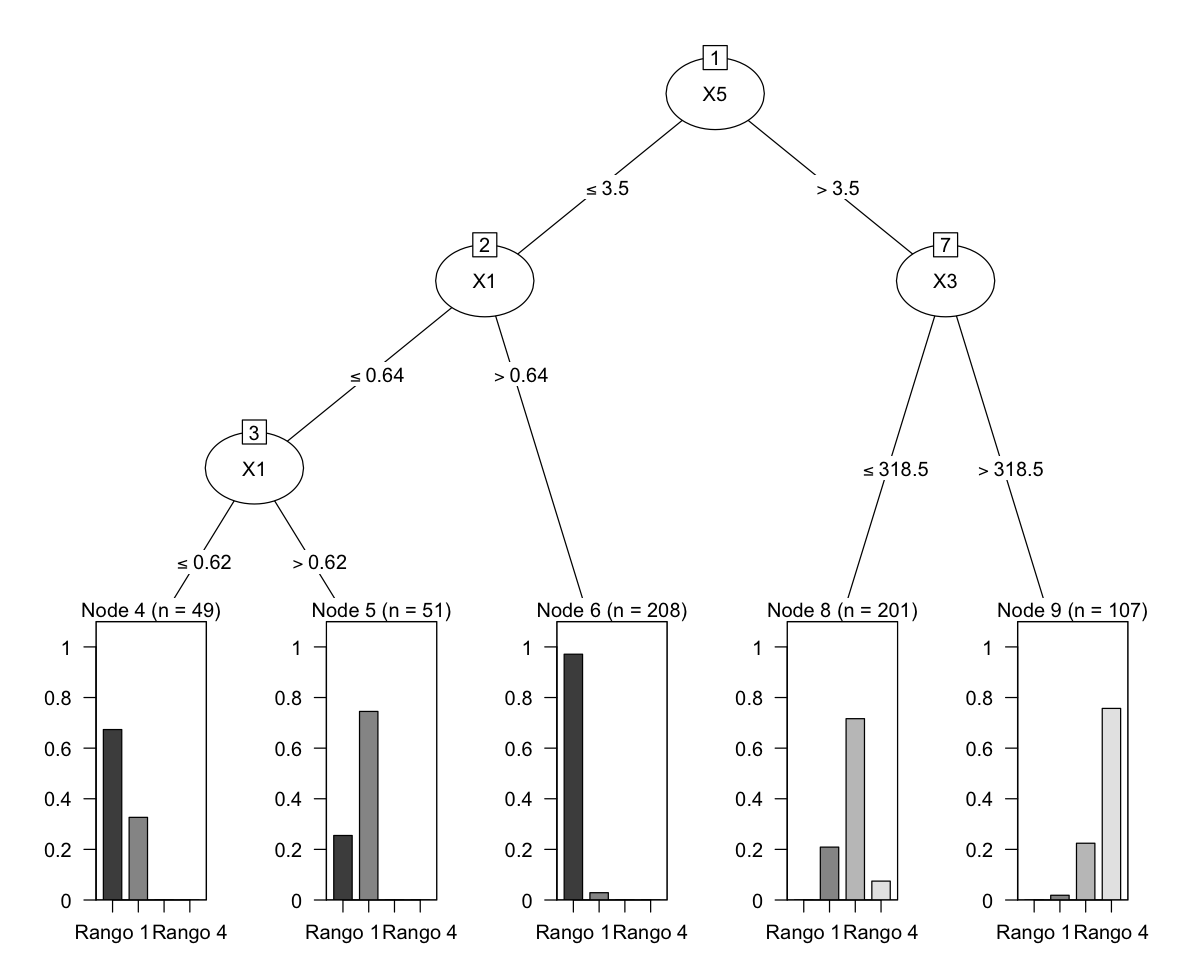

In [180]:
options(repr.plot.width=10, repr.plot.height=8)
plot( sm.tree_reduced )

In [181]:
summary( tree.rules_reduced )


Call:
C5.0.default(x = sm_train.set_reduced[, -ncol(sm_train.set_reduced)], y
 = sm_train.set_reduced$Y1_group, rules = T)


C5.0 [Release 2.07 GPL Edition]  	Thu Jun 20 18:27:56 2024
-------------------------------

Class specified by attribute `outcome'

Read 616 cases (6 attributes) from undefined.data

Rules:

Rule 1: (308/60, lift 2.0)
	X5 <= 3.5
	->  class Rango 1  [0.803]

Rule 2: (51/13, lift 4.4)
	X1 > 0.62
	X1 <= 0.64
	->  class Rango 2  [0.736]

Rule 3: (100/46, lift 3.2)
	X1 <= 0.64
	->  class Rango 2  [0.539]

Rule 4: (308/140, lift 2.0)
	X5 > 3.5
	->  class Rango 3  [0.545]

Rule 5: (107/26, lift 4.8)
	X3 > 318.5
	X5 > 3.5
	->  class Rango 4  [0.752]

Default class: Rango 1


Evaluation on training data (616 cases):

	        Rules     
	  ----------------
	    No      Errors

	     5  118(19.2%)   <<


	   (a)   (b)   (c)   (d)    <-classified as
	  ----  ----  ----  ----
	   235    13                (a): class Rango 1
	    22    38    42     2    (b): class Rango 2
	  

En este modelo de clasificación utilizando C5.0, se han generado cinco reglas basadas en los datos de entrenamiento. Cada regla define condiciones específicas sobre los atributos (`X1`, `X3`, `X5`) para clasificar los datos en una de las cuatro clases (`Rango 1`, `Rango 2`, `Rango 3`, `Rango 4`). La mayoría de los datos se clasifican utilizando el atributo `X5`, que es el más utilizado en las reglas (100% de uso).


In [182]:
conf.matrix.tree_reduced <- confusionMatrix(table( sm_test.set_reduced$Y1_group, tree.pred.class_reduced ))
print( conf.matrix.tree_reduced )

Confusion Matrix and Statistics

         tree.pred.class_reduced
          Rango 1 Rango 2 Rango 3 Rango 4
  Rango 1      60       1       0       0
  Rango 2       3      12      10       0
  Rango 3       0       0      40       2
  Rango 4       0       0       5      19

Overall Statistics
                                          
               Accuracy : 0.8618          
                 95% CI : (0.7966, 0.9124)
    No Information Rate : 0.4145          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.802           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Rango 1 Class: Rango 2 Class: Rango 3
Sensitivity                  0.9524        0.92308         0.7273
Specificity                  0.9888        0.90647         0.9794
Pos Pred Value               0.9836        0.48000         0.9524
Neg Pred Value               0

El análisis de la matriz de confusión y las estadísticas asociadas para el modelo de clasificación C5.0 muestra un alto nivel de precisión general (86.18%) con un intervalo de confianza del 95% entre 79.66% y 91.24%. El valor de Kappa es 0.802, indicando una buena concordancia entre las predicciones del modelo y las clases reales. En detalle, la sensibilidad por clase varía, siendo más alta para Rango 1 (95.24%) y Rango 4 (90.48%), mientras que Rango 3 tiene la menor sensibilidad (72.73%). La especificidad es alta en todas las clases, con valores superiores al 90%. Los valores predichos positivos y negativos también son altos, especialmente para Rango 1 y Rango 4. La prevalencia de las clases y las tasas de detección se alinean con la distribución de los datos, y la precisión balanceada por clase es alta, indicando un rendimiento robusto del modelo en la clasificación de cada rango.

## Boosting

Para mejorar el modelo, se utiliza el concepto de Boosting, que combina varios modelos de bajo rendimiento para formar un conjunto más potente. Este enfoque aprovecha las fortalezas y debilidades complementarias de cada modelo, mejorando significativamente la precisión del clasificador. La función C5.0() en R permite añadir Boosting a nuestro árbol de decisión añadiendo un parámetro que especifica el número de árboles a usar.

In [183]:
sm.tree_reduced <- C5.0(Y1_group ~ ., data = sm_train.set_reduced, trials = 10)


In [184]:
any(is.na(sm_test.set_reduced))

sm_test.set_reduced <- na.omit(sm_test.set_reduced)


[1] FALSE

Se realizan nuevamente las predicciones

In [185]:
# Predicción de clases con instancia de pruebas
tree.pred.class_reduced <- predict(sm.tree_reduced, sm_test.set_reduced[, -ncol(sm_test.set_reduced)], type = "class")

# Probabilidad por clases
tree.pred.prob_reduced <- predict(sm.tree_reduced, sm_test.set_reduced[, -ncol(sm_test.set_reduced)], type = "prob")


In [186]:

confusionMatrix(data = tree.pred.class_reduced, reference = sm_test.set_reduced$Y1_group, positive = "yes")


Confusion Matrix and Statistics

          Reference
Prediction Rango 1 Rango 2 Rango 3 Rango 4
   Rango 1      61      15       0       0
   Rango 2       0       0       0       0
   Rango 3       0      10      40       5
   Rango 4       0       0       2      19

Overall Statistics
                                         
               Accuracy : 0.7895         
                 95% CI : (0.716, 0.8513)
    No Information Rate : 0.4013         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6893         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Rango 1 Class: Rango 2 Class: Rango 3
Sensitivity                  1.0000         0.0000         0.9524
Specificity                  0.8352         1.0000         0.8636
Pos Pred Value               0.8026            NaN         0.7273
Neg Pred Value               1.0000         0.8

El análisis de la matriz de confusión y las estadísticas asociadas para el modelo de Boosting con C5.0 muestra una precisión general del 78.95% con un intervalo de confianza del 95% entre 71.60% y 85.13%. El valor de Kappa es 0.6893, indicando una buena concordancia entre las predicciones del modelo y las clases reales. En detalle, la sensibilidad por clase varía significativamente: Rango 1 tiene una sensibilidad del 100%, mientras que Rango 2 no tiene ninguna predicción correcta (0%), Rango 3 tiene una sensibilidad del 95.24%, y Rango 4 tiene una sensibilidad del 79.17%. La especificidad es alta en todas las clases, superando el 83%. Los valores predichos positivos son altos para Rango 1 y Rango 4, pero no se calculan para Rango 2 debido a la ausencia de predicciones correctas. La precisión balanceada por clase es alta para Rango 1, Rango 3, y Rango 4, indicando un rendimiento razonablemente robusto del modelo, excepto en Rango 2, donde el modelo no logró hacer predicciones correctas.

In [187]:
#modeloc50_1 <- C5.0(data_training[-17], data_training$default, trials = 10) 
#data_predicted2 <- predict(modeloc50_1, data_test)
#confusionMatrix(data = data_predicted2, reference = data_test$default, positive = "yes")


A continuación, se evaluará el impacto del número de ensayos (trials) en la precisión del modelo de Boosting con C5.0 a través de diferentes números de ensayos: 1, 5, 10, 20, 50 y 100. En cada iteración, se ajustará un modelo de Boosting con el número especificado de ensayos utilizando el conjunto de datos de entrenamiento reducido (sm_train.set_reduced). Posteriormente, se realizará la predicción de las clases en el conjunto de prueba reducido (sm_test.set_reduced) y se calculará la matriz de confusión para obtener la precisión del modelo. Finalmente, se almacenarán los resultados de precisión en el data frame accuracy_results. La idea es analizar cómo varía la precisión del modelo en función del número de ensayos.

In [188]:
accuracy_results <- data.frame(Trials = integer(), Accuracy = double())

for (trials in c(1, 5, 10, 20, 50, 100)) {
  sm.tree_reduced <- C5.0(Y1_group ~ ., data = sm_train.set_reduced, trials = trials)
  tree.pred.class_reduced <- predict(sm.tree_reduced, sm_test.set_reduced[, -ncol(sm_test.set_reduced)], type = "class")
  
  cm <- confusionMatrix(data = tree.pred.class_reduced, reference = sm_test.set_reduced$Y1_group, positive = "yes")
  
  accuracy_results <- rbind(accuracy_results, data.frame(Trials = trials, Accuracy = cm$overall["Accuracy"]))
}

print(accuracy_results)

          Trials  Accuracy
Accuracy       1 0.8618421
Accuracy1      5 0.8026316
Accuracy2     10 0.7894737
Accuracy3     20 0.8618421
Accuracy4     50 0.7894737
Accuracy5    100 0.7894737


Los resultados muestran que la precisión del modelo de Boosting varía con el número de ensayos. Con 1 y 20 ensayos, el modelo alcanza una precisión del 86.18%, mientras que con 5, 10, 50 y 100 ensayos, la precisión disminuye a aproximadamente 79%. Esto sugiere que un número moderado de ensayos (como 1 o 20) es más efectivo para este conjunto de datos, mientras que demasiados ensayos pueden introducir ruido o sobreajuste, perjudicando la precisión del modelo.

Se utiliará validación cruzada para sintonizar el modelo C5.0. Primero, se establece un control de entrenamiento con validación cruzada de 10 pliegues. Luego, se entrena el modelo utilizando diferentes números de ensayos para encontrar el mejor rendimiento. Finalmente, se selecciona el mejor modelo basado en la validación cruzada y se usa para predecir las clases en el conjunto de datos de prueba, evaluando su precisión mediante una matriz de confusión.

In [189]:
train_control <- trainControl(method = "cv", number = 10)

tuned_model <- train(
  Y1_group ~ ., 
  data = sm_train.set_reduced, 
  method = "C5.0",
  trControl = train_control,
  tuneGrid = expand.grid(trials = c(1, 5, 10, 20, 50, 100), model = "tree", winnow = FALSE)
)

print(tuned_model$bestTune)

best_model <- C5.0(Y1_group ~ ., data = sm_train.set_reduced, trials = tuned_model$bestTune$trials)
tree.pred.class_reduced <- predict(best_model, sm_test.set_reduced[, -ncol(sm_test.set_reduced)], type = "class")

cm <- confusionMatrix(data = tree.pred.class_reduced, reference = sm_test.set_reduced$Y1_group, positive = "yes")
print(cm)

Warning message:
"'trials' should be <= 24 for this object. Predictions generated using 24 trials"
Warning message:
"'trials' should be <= 28 for this object. Predictions generated using 28 trials"
Warning message:
"'trials' should be <= 21 for this object. Predictions generated using 21 trials"
Warning message:
"'trials' should be <= 23 for this object. Predictions generated using 23 trials"
Warning message:
"'trials' should be <= 22 for this object. Predictions generated using 22 trials"
Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"
Warning message:
"'trials' should be <= 23 for this object. Predictions generated using 23 trials"
Warning message:
"'trials' should be <= 19 for this object. Predictions generated using 19 trials"
Warning message:
"'trials' should be <= 19 for this object. Predictions generated using 19 trials"
Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"
Warning me

  trials model winnow
1      1  tree  FALSE
Confusion Matrix and Statistics

          Reference
Prediction Rango 1 Rango 2 Rango 3 Rango 4
   Rango 1      60       3       0       0
   Rango 2       1      12       0       0
   Rango 3       0      10      40       5
   Rango 4       0       0       2      19

Overall Statistics
                                          
               Accuracy : 0.8618          
                 95% CI : (0.7966, 0.9124)
    No Information Rate : 0.4013          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.802           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Rango 1 Class: Rango 2 Class: Rango 3
Sensitivity                  0.9836        0.48000         0.9524
Specificity                  0.9670        0.99213         0.8636
Pos Pred Value               0.9524        0.92308         0

Después de realizar la validación cruzada y la sintonización, el mejor modelo encontrado utiliza solo un ensayo (trials = 1). Los mensajes de advertencia indican que en algunas iteraciones de la validación cruzada, el número máximo de ensayos permitidos por el modelo fue menor que el especificado, y se utilizaron esos valores máximos permitidos para las predicciones.

# 4. No dimensionalidad (sin pca)

Es fundamental realizar una comparación de métricas con un modelo que incluya todas las variables del conjunto de datos. Esto nos permitirá validar claramente los datos y evaluar si el desbalanceo de los datos o la varianza total explicada influyen en los resultados finales, si la diferencia en mejora es mínima en comparación con el conjunto reducido.

In [190]:
data_raw

X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Y1_group
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.98,514.5,294.0,110.25,7.0,2,0,0,15.55,21.33,Rango 2
0.98,514.5,294.0,110.25,7.0,3,0,0,15.55,21.33,Rango 2
0.98,514.5,294.0,110.25,7.0,4,0,0,15.55,21.33,Rango 2
0.98,514.5,294.0,110.25,7.0,5,0,0,15.55,21.33,Rango 2
0.90,563.5,318.5,122.50,7.0,2,0,0,20.84,28.28,Rango 2
0.90,563.5,318.5,122.50,7.0,3,0,0,21.46,25.38,Rango 2
0.90,563.5,318.5,122.50,7.0,4,0,0,20.71,25.16,Rango 2
0.90,563.5,318.5,122.50,7.0,5,0,0,19.68,29.60,Rango 2
0.86,588.0,294.0,147.00,7.0,2,0,0,19.50,27.30,Rango 2


In [191]:
data_raw <- data_raw[, c("X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y1_group")]

### Conjuntos de entrenamiento y prueba
Similar a lo abordado en la sección anterior, se empleará una división 80-20 para los conjuntos de datos de entrenamiento y prueba, respectivamente.

In [192]:
set.seed( 1237 )

sm_indexes   <- createDataPartition( data_raw$Y1_group, p=0.80, list = F )
sm_train.set <- sm_reduced[sm_indexes,]
sm_test.set  <- sm_reduced[-sm_indexes,]

In [193]:
prop.table(table(sm_train.set$Y1_group))


  Rango 1   Rango 2   Rango 3   Rango 4 
0.4025974 0.1688312 0.2727273 0.1558442 

In [194]:
prop.table(table(sm_test.set$Y1_group))


  Rango 1   Rango 2   Rango 3   Rango 4 
0.4013158 0.1644737 0.2763158 0.1578947 

Las distribuciones de los rangos en ambos conjuntos de datos son muy similares, con diferencias mínimas en cada rango. Estas pequeñas variaciones no indican un desbalance significativo. El grupo más representado en ambos conjuntos es el Rango 1, seguido por el Rango 3. Los Rangos 2 y 4 tienen menor representación, con diferencias apenas perceptibles entre los dos conjuntos de datos. Esto sugiere una estabilidad en la distribución de los datos entre los dos conjuntos, sin un desbalance considerable en ninguno de los rangos.

In [195]:
#Modelo de clasificación con instancia de entrenamiento
sm.tree <- C5.0( Y1_group ~ ., sm_train.set ) 

#Modelo basado en reglas
tree.rules <- C5.0( x = sm_train.set[, -ncol(sm_train.set) ], y = sm_train.set$Y1_group, rules = T )

In [196]:
summary( tree.rules )


Call:
C5.0.default(x = sm_train.set[, -ncol(sm_train.set)], y
 = sm_train.set$Y1_group, rules = T)


C5.0 [Release 2.07 GPL Edition]  	Thu Jun 20 18:27:58 2024
-------------------------------

Class specified by attribute `outcome'

Read 616 cases (6 attributes) from undefined.data

Rules:

Rule 1: (308/60, lift 2.0)
	X5 <= 3.5
	->  class Rango 1  [0.803]

Rule 2: (51/13, lift 4.4)
	X1 > 0.62
	X1 <= 0.64
	->  class Rango 2  [0.736]

Rule 3: (100/46, lift 3.2)
	X1 <= 0.64
	->  class Rango 2  [0.539]

Rule 4: (308/140, lift 2.0)
	X5 > 3.5
	->  class Rango 3  [0.545]

Rule 5: (107/26, lift 4.8)
	X3 > 318.5
	X5 > 3.5
	->  class Rango 4  [0.752]

Default class: Rango 1


Evaluation on training data (616 cases):

	        Rules     
	  ----------------
	    No      Errors

	     5  118(19.2%)   <<


	   (a)   (b)   (c)   (d)    <-classified as
	  ----  ----  ----  ----
	   235    13                (a): class Rango 1
	    22    38    42     2    (b): class Rango 2
	               144    24  

### Predicciones

In [197]:
#Predicción de clases con instancia de pruebas
tree.pred.class <- predict( sm.tree, sm_test.set[, -ncol(sm_test.set) ], type = "class" )

#Probabilidad por clases
tree.pred.prob <- predict( sm.tree, sm_test.set[, -ncol(sm_test.set) ], type = "prob" )

In [198]:
head( tree.pred.prob, 3 )

,Rango 1,Rango 2,Rango 3,Rango 4
2,0.001993056,0.20875659,0.714221420,0.0750289288
6,0.001993056,0.20875659,0.714221420,0.0750289288
26,0.968433481,0.02951594,0.001304915,0.0007456658


In [199]:
tree.pred.class

[1] Rango 3 Rango 3 Rango 1 Rango 1 Rango 1 Rango 1 Rango 3 Rango 3 Rango 3
 [10] Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 3 Rango 3 Rango 3 Rango 3
 [19] Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 2 Rango 1
 [28] Rango 3 Rango 3 Rango 3 Rango 4 Rango 4 Rango 2 Rango 1 Rango 3 Rango 3
 [37] Rango 4 Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 3
 [46] Rango 3 Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 3 Rango 3 Rango 4
 [55] Rango 4 Rango 1 Rango 1 Rango 1 Rango 2 Rango 1 Rango 3 Rango 3 Rango 3
 [64] Rango 3 Rango 3 Rango 3 Rango 4 Rango 1 Rango 1 Rango 2 Rango 1 Rango 3
 [73] Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 4 Rango 2 Rango 1 Rango 1
 [82] Rango 3 Rango 3 Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1
 [91] Rango 2 Rango 1 Rango 1 Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 4
[100] Rango 4 Rango 4 Rango 1 Rango 2 Rango 1 Rango 3 Rango 3 Rango 3 Rango 4
[109] Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 1 Rango 3 Rango 3 Rango 3
[118] Rango 3 Rango 3 Rango 1 Rango 3 Rango 4 Rango 1 Rango 1 Rango 1 Rango 2
[127] Rango 1 Rango 3 Rango 3 Rango 3 Rango 4 Rango 4 Rango 4 Rango 1 Rango 1
[136] Rango 2 Rango 1 Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 3 Rango 4
[145] Rango 4 Rango 1 Rango 1 Rango 1 Rango 1 Rango 1 Rango 2 Rango 1
Levels: Rango 1 Rango 2 Rango 3 Rango 4

In [200]:
dev.new( width=2, height=1 )

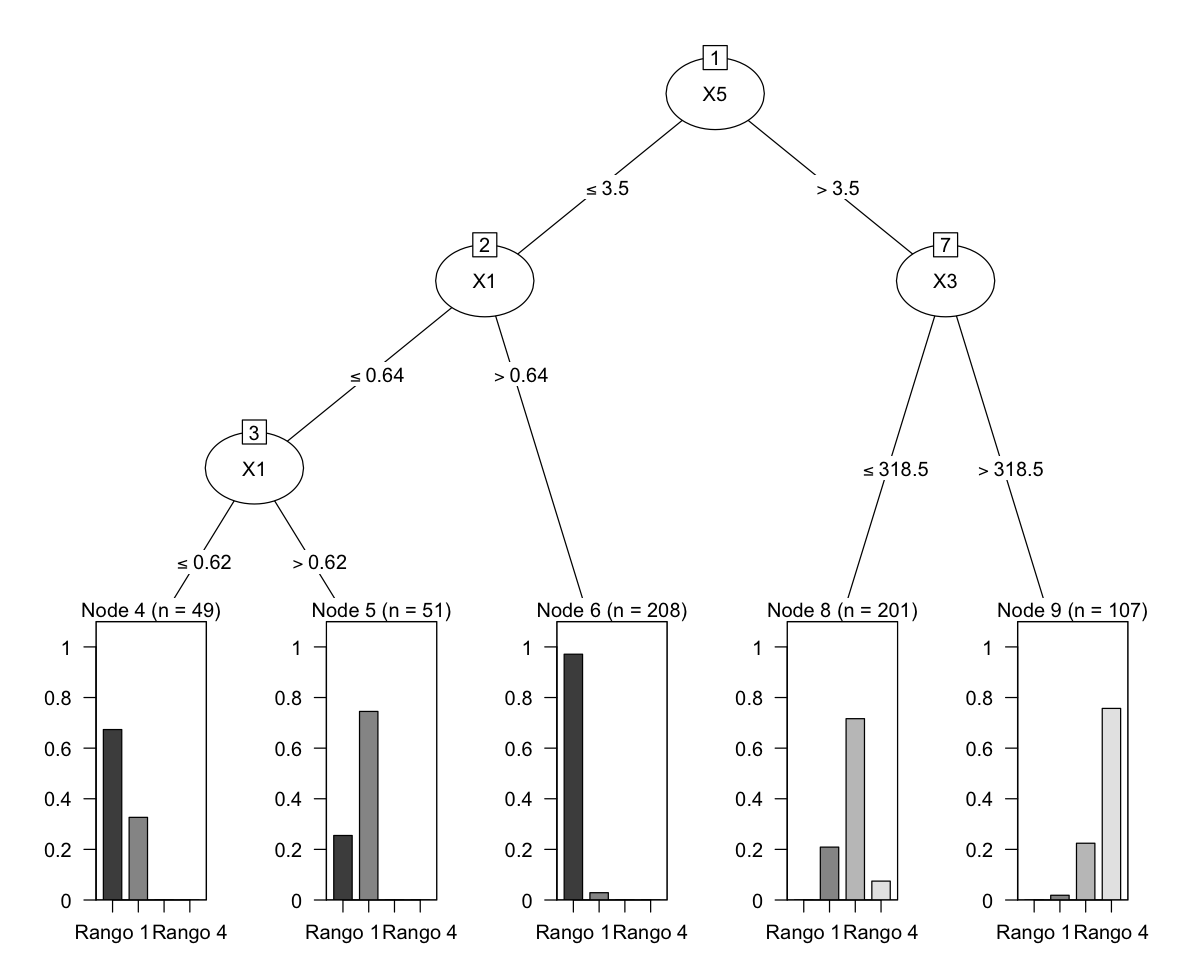

In [201]:
plot( sm.tree )

In [202]:
summary( tree.rules )


Call:
C5.0.default(x = sm_train.set[, -ncol(sm_train.set)], y
 = sm_train.set$Y1_group, rules = T)


C5.0 [Release 2.07 GPL Edition]  	Thu Jun 20 18:27:58 2024
-------------------------------

Class specified by attribute `outcome'

Read 616 cases (6 attributes) from undefined.data

Rules:

Rule 1: (308/60, lift 2.0)
	X5 <= 3.5
	->  class Rango 1  [0.803]

Rule 2: (51/13, lift 4.4)
	X1 > 0.62
	X1 <= 0.64
	->  class Rango 2  [0.736]

Rule 3: (100/46, lift 3.2)
	X1 <= 0.64
	->  class Rango 2  [0.539]

Rule 4: (308/140, lift 2.0)
	X5 > 3.5
	->  class Rango 3  [0.545]

Rule 5: (107/26, lift 4.8)
	X3 > 318.5
	X5 > 3.5
	->  class Rango 4  [0.752]

Default class: Rango 1


Evaluation on training data (616 cases):

	        Rules     
	  ----------------
	    No      Errors

	     5  118(19.2%)   <<


	   (a)   (b)   (c)   (d)    <-classified as
	  ----  ----  ----  ----
	   235    13                (a): class Rango 1
	    22    38    42     2    (b): class Rango 2
	               144    24  

In [203]:
conf.matrix.tree <- confusionMatrix(table( sm_test.set$Y1_group, tree.pred.class ))
print( conf.matrix.tree )

Confusion Matrix and Statistics

         tree.pred.class
          Rango 1 Rango 2 Rango 3 Rango 4
  Rango 1      60       1       0       0
  Rango 2       3      12      10       0
  Rango 3       0       0      40       2
  Rango 4       0       0       5      19

Overall Statistics
                                          
               Accuracy : 0.8618          
                 95% CI : (0.7966, 0.9124)
    No Information Rate : 0.4145          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.802           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Rango 1 Class: Rango 2 Class: Rango 3
Sensitivity                  0.9524        0.92308         0.7273
Specificity                  0.9888        0.90647         0.9794
Pos Pred Value               0.9836        0.48000         0.9524
Neg Pred Value               0.9670   

# 5. Tratamiento datos atípicos

La Distancia de Cook es una medida en regresión que identifica puntos influyentes u outliers que afectan significativamente los parámetros del modelo. Una alta distancia de Cook sugiere que la observación tiene un impacto considerable en los resultados del modelo y puede necesitar revisión o eliminación para mejorar la fiabilidad del análisis.

In [204]:

data_raw$Y1_group <- as.numeric( data_raw$Y1_group )
model <- lm(Y1_group ~ ., data=data_raw)
cooksd <- cooks.distance(model)
cooksd

1            2            3            4            5            6 
1.791763e-03 1.593199e-03 1.578225e-03 1.741716e-03 3.673477e-03 3.066492e-03 
           7            8            9           10           11           12 
3.050704e-03 3.617030e-03 4.031784e-03 3.471883e-03 3.453095e-03 3.966683e-03 
          13           14           15           16           17           18 
6.391395e-03 5.413833e-03 5.391870e-03 6.313922e-03 6.656647e-05 5.902858e-05 
          19           20           21           22           23           24 
6.136470e-05 7.478892e-05 1.524879e-03 2.654663e-02 1.351074e-03 2.918844e-02 
          25           26           27           28           29           30 
3.737116e-03 3.259899e-03 3.278288e-03 3.800719e-03 1.757934e-03 1.509161e-03 
          31           32           33           34           35           36 
1.520857e-03 1.799126e-03 7.728459e-04 6.422393e-04 6.490536e-04 7.977084e-04 
          37           38           39           40           41           42 
1.832626e-04 1.540175e-04 1.573651e-04 1.954747e-04 1.205029e-05 1.111069e-05 
          43           44           45           46           47           48 
1.209976e-05 1.556827e-05 7.789120e-05 6.598358e-05 6.318224e-05 6.838298e-05 
          49           50           51           52           53           54 
3.035531e-03 2.665651e-03 2.682690e-03 3.094115e-03 3.040091e-04 2.356308e-04 
          55           56           57           58           59           60 
2.390651e-04 3.174970e-04 5.164844e-04 4.279250e-04 4.334076e-04 5.365921e-04 
          61           62           63           64           65           66 
6.721479e-03 5.279351e-03 5.261965e-03 6.655291e-03 6.144310e-03 4.882024e-03 
          67           68           69           70           71           72 
4.898969e-03 6.208512e-03 3.166054e-03 2.780932e-03 2.762548e-03 3.103680e-03 
          73           74           75           76           77           78 
1.247241e-03 1.032495e-03 1.041091e-03 1.278654e-03 3.784758e-04 3.034974e-04 
          79           80           81           82           83           84 
3.077202e-04 3.944952e-04 7.541806e-05 5.616957e-05 5.768388e-05 8.168448e-05 
          85           86           87           88           89           90 
7.228972e-06 4.792956e-06 4.363318e-06 5.451758e-06 5.088841e-03 1.095187e-04 
          91           92           93           94           95           96 
3.964076e-03 1.354894e-04 6.864631e-04 5.764188e-04 5.692769e-04 6.612614e-04 
          97           98           99          100          101          102 
3.226315e-03 2.770350e-03 2.753717e-03 3.168553e-03 2.427801e-04 1.801820e-04 
         103          104          105          106          107          108 
1.829284e-04 2.540523e-04 4.308941e-04 3.490150e-04 3.536656e-04 4.483502e-04 
         109          110          111          112          113          114 
6.077926e-03 4.616301e-03 4.601247e-03 6.018659e-03 5.346775e-03 4.114126e-03 
         115          116          117          118          119          120 
4.128556e-03 5.403234e-03 3.088889e-03 2.691730e-03 2.674283e-03 3.029214e-03 
         121          122          123          124          125          126 
1.071979e-03 8.680547e-04 8.754672e-04 1.099676e-03 3.085224e-04 2.396321e-04 
         127          128          129          130          131          132 
2.431117e-04 3.221589e-04 5.426043e-05 3.793783e-05 3.905076e-05 5.917791e-05 
         133          134          135          136          137          138 
9.845567e-06 6.232284e-06 5.792120e-06 7.901806e-06 4.374290e-03 1.050591e-04 
         139          140          141          142          143          144 
3.274987e-03 1.356145e-04 6.791895e-04 5.622926e-04 5.555758e-04 6.551391e-04 
         145          146          147          148          149          150 
3.348731e-03 2.876425e-03 2.859461e-03 3.289833e-03 2.216436e-04 1.647938e-04 
         151          152          153          154          


En el gráfico generado, se debería observar las distancias de Cook para cada observación del conjunto de datos. Los puntos representan las observaciones, y aquellos con valores de distancia de Cook significativamente altos se consideran influyentes en el modelo de regresión.


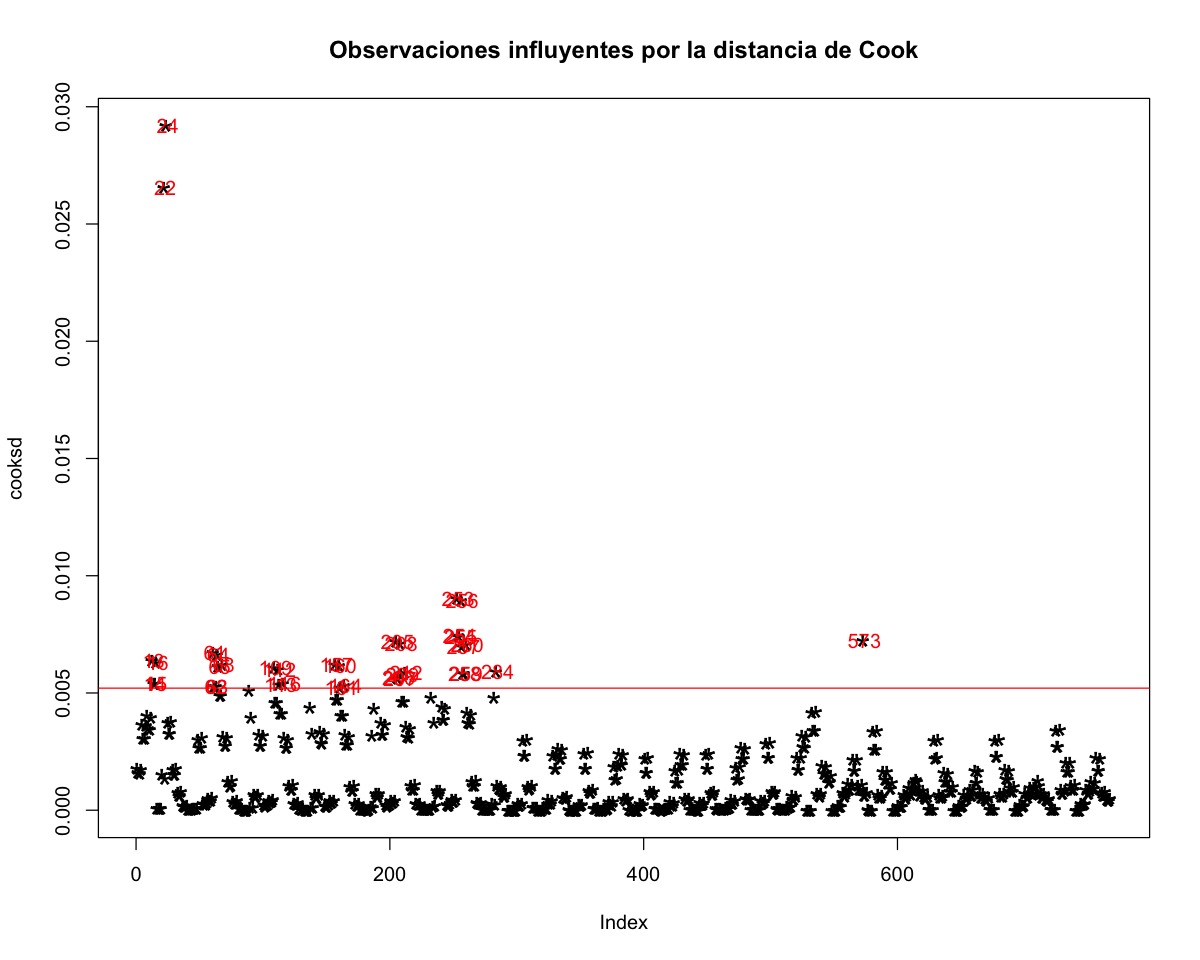

In [205]:
plot(cooksd, pch="*", cex=2, main="Observaciones influyentes por la distancia de Cook")
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

Las observaciones etiquetadas como 22 y 24 están por encima del umbral, lo que indica que estos puntos son particularmente influyentes y tienen un impacto desproporcionado en el modelo. Esto sugiere que estas observaciones podrían necesitar ser revisadas o eliminadas para mejorar la fiabilidad y la precisión del modelo de regresión.

In [206]:
influential <- as.numeric(names(cooksd)[(cooksd > 4*mean(cooksd, na.rm=T))])
head( data_raw[influential, ] )

,X1,X2,X3,X4,X5,X6,X7,X8,Y1_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13,0.82,612.5,318.5,147.0,7,2,0,0,2
14,0.82,612.5,318.5,147.0,7,3,0,0,2
15,0.82,612.5,318.5,147.0,7,4,0,0,2
16,0.82,612.5,318.5,147.0,7,5,0,0,2
22,0.76,661.5,416.5,122.5,7,3,0,0,2
24,0.76,661.5,416.5,122.5,7,5,0,0,2


## Prueba de los datos atípicos


Se convierte la variable Y1_group a un factor para tratarla como categórica. Luego, se utiliza la función outlier para detectar valores atípicos en el conjunto de datos data_raw, excluyendo la última columna (Y1_group). 

In [207]:
data_raw$Y1_group <- as.factor( data_raw$Y1_group )

outlier(data_raw[, -ncol(data_raw)])

head( scores(data_raw[, -ncol(data_raw)]), 3 )

X1     X2     X3     X4     X5     X6     X7     X8 
  0.98 514.50 416.50 110.25   7.00   5.00   0.00   0.00

,X1,X2,X3,X4,X5,X6,X7,X8
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.040447,-1.784712,-0.5615855,-1.469119,0.9993487,-1.3407670,-1.7593,-1.813393
2,2.040447,-1.784712,-0.5615855,-1.469119,0.9993487,-0.4469223,-1.7593,-1.813393
3,2.040447,-1.784712,-0.5615855,-1.469119,0.9993487,0.4469223,-1.7593,-1.813393


### Tratamiento de los datos atípicos

Se define la función outlier_norm para tratar outliers reemplazando los valores extremos con los percentiles 5 y 95. Luego, se aplica esta función a las primeras ocho columnas del data frame data_raw para crear un nuevo data frame data_raw_fixed, donde los outliers han sido ajustados según la lógica definida en la función.

In [208]:
outlier_norm <- function(x){
   qntile <- quantile(x, probs=c(.25, .75))
   caps <- quantile(x, probs=c(.05, .95))
   H <- 1.5 * IQR(x, na.rm = T)
   x[x < (qntile[1] - H)] <- caps[1]
   x[x > (qntile[2] + H)] <- caps[2]
   return(x)
}

data_raw_fixed <- data_raw

data_raw_fixed <- apply(data_raw_fixed[1:8], 2, outlier_norm)


In [209]:

data_raw_fixed <- data.frame( data_raw_fixed, Y1_group = data_raw$Y1_group )

Es necesario realizar una serie de pasos para ajustar un modelo de regresión y evaluar la influencia de las observaciones. 

Primero, se convierte Y1_group a una variable numérica y se eliminan las filas 22 y 24 del data frame data_raw_fixed. 

Luego, se ajusta un modelo de regresión lineal usando Y1_group como variable dependiente y el resto de las variables como independientes. Se calcula la distancia de Cook para identificar observaciones influyentes.

,X1,X2,X3,X4,X5,X6,X7,X8,Y1_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.98,514.5,294,110.25,7,2,0,0,2
2,0.98,514.5,294,110.25,7,3,0,0,2
3,0.98,514.5,294,110.25,7,4,0,0,2


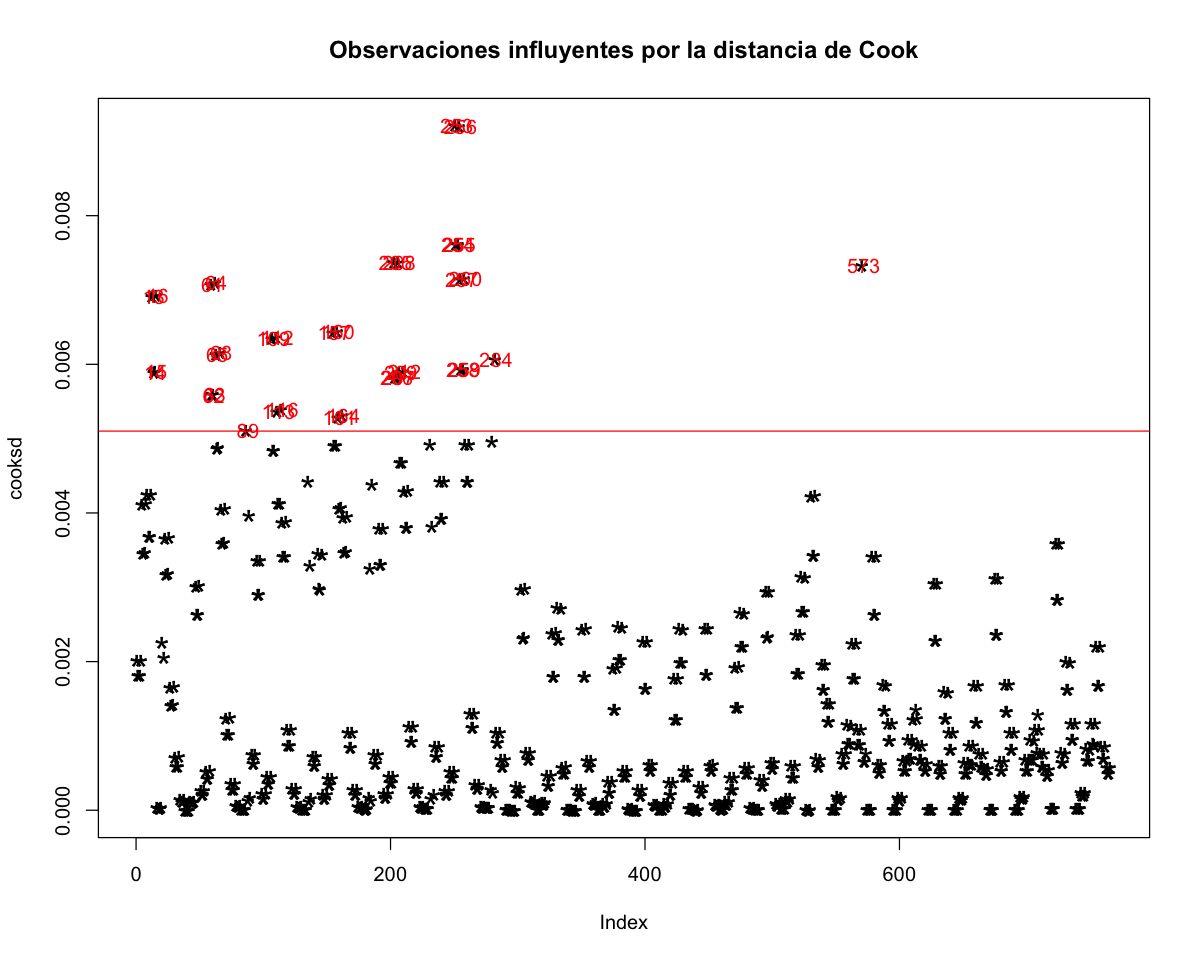

In [210]:

data_raw_fixed$Y1_group <- as.numeric(data_raw_fixed$Y1_group)
data_raw_fixed <- data_raw_fixed[ -24, ]
data_raw_fixed <- data_raw_fixed[ -22, ]
head( data_raw_fixed, 3 )

model <- lm(Y1_group ~ ., data=data_raw_fixed)
cooksd <- cooks.distance(model)
plot(cooksd, pch="*", cex=2, main="Observaciones influyentes por la distancia de Cook")
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

Se puede observar que ahora el rango de eror va desde 0 a 0.009.

 se equilibrarán las clases del conjunto de datos data_raw_fixed utilizando la técnica SMOTE (Synthetic Minority Over-sampling Technique). Primero, se convertirá Y1_group a una variable numérica y se aplicará SMOTE para generar un conjunto de datos balanceado (data_balanced). Luego, se eliminará la columna class generada por SMOTE. Finalmente, se mostrarán las primeras tres filas del conjunto de datos balanceado y sus dimensiones.

In [212]:
#cambiar nombre de data_balanced
set.seed(2346)

data_raw_fixed$Y1_group <- as.numeric( data_raw_fixed$Y1_group )
data_balanced <- SMOTE(data_raw_fixed, data_raw_fixed$Y1_group, K=5)$data

drops <- "class"
data_balanced <- data_balanced[ , !(names(data_balanced) %in% drops)]

head( data_balanced, 3)
dim( data_balanced )

,X1,X2,X3,X4,X5,X6,X7,X8,Y1_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.90,563.5,318.5,122.5,7,2,0.4,3,4
2,0.76,661.5,416.5,122.5,7,3,0.4,2,4
3,0.90,563.5,318.5,122.5,7,2,0.4,4,4


[1] 1246    9

Se dividirá el conjunto de datos balanceado data_balanced en conjuntos de entrenamiento y prueba, utilizando una partición del 80% para el entrenamiento.

In [213]:
set.seed( 8474366 )

data_balanced$Y1_group <- as.factor( data_balanced$Y1_group )

data_balanced_indexes   <- createDataPartition( data_balanced$Y1_group, p=0.80, list = F )
data_balanced_train.set <- data_balanced[data_balanced_indexes,]
data_balanced_test.set  <- data_balanced[-data_balanced_indexes,]

In [214]:
prop.table(table(data_balanced_train.set$Y1_group))


        1         2         3         4 
0.2484970 0.1022044 0.1683367 0.4809619 

In [215]:
prop.table(table(data_balanced_test.set$Y1_group))


        1         2         3         4 
0.2459677 0.1008065 0.1693548 0.4838710 

Las distribuciones de los rangos en ambos conjuntos de datos son prácticamente idénticas, con diferencias mínimas en cada rango. Estas pequeñas variaciones no indican un desbalance significativo. La mayor proporción de observaciones en ambos conjuntos corresponde al Rango 4, seguido por el Rango 1, con los Rangos 2 y 3 teniendo menor representación. Estas ligeras diferencias sugieren una estabilidad en la distribución de los datos entre los dos conjuntos, sin un desbalance considerable en ninguno de los rangos.

### Modelo con valores atípicos

In [216]:
#Modelo de clasificación con instancia de entrenamiento
data_balanced.tree_reduced <- C5.0( Y1_group ~ ., data_balanced_train.set, trials=20) 

#Modelo basado en reglas
tree.rules_balanced_reduced <- C5.0( x = data_balanced_train.set[, -1 ], y = data_balanced_train.set$Y1_group, rules = T )

In [217]:
summary( data_balanced.tree_reduced )


Call:
C5.0.formula(formula = Y1_group ~ ., data = data_balanced_train.set, trials
 = 20)


C5.0 [Release 2.07 GPL Edition]  	Thu Jun 20 18:31:43 2024
-------------------------------

Class specified by attribute `outcome'

Read 998 cases (9 attributes) from undefined.data

-----  Trial 0:  -----

Decision tree:

X5 <= 3.5:
:...X1 > 0.64: 1 (210/4)
:   X1 <= 0.64:
:   :...X7 > 0.3213589: 2 (34/1)
:       X7 <= 0.3213589:
:       :...X1 <= 0.62: 1 (31)
:           X1 > 0.62:
:           :...X7 <= 0.1692678: 1 (17/7)
:               X7 > 0.1692678: 2 (14)
X5 > 3.5:
:...X3 > 318.5:
    :...X7 > 0.1: 4 (355)
    :   X7 <= 0.1:
    :   :...X1 <= 0.76: 3 (21)
    :       X1 > 0.76:
    :       :...X7 <= 0: 3 (2)
    :           X7 > 0: 4 (48)
    X3 <= 318.5:
    :...X7 > 0.3213589:
        :...X3 <= 294: 3 (27)
        :   X3 > 294:
        :   :...X1 <= 0.86: 3 (13)
        :       X1 > 0.86: 4 (77)
        X7 <= 0.3213589:
        :...X8 <= 0: 2 (13)
            X8 > 0:
            :...X7

El análisis del árbol de decisión generado por el modelo C5.0 con 20 ensayos muestra un rendimiento excelente, con un error general del 0.7% en los datos de entrenamiento. El árbol utiliza principalmente los atributos X5, X7, X8 y X1, que fueron empleados en el 100% de las decisiones, seguidos por X3, X4 y X6. La clasificación es altamente precisa, especialmente para las clases 1 y 4, con mínimos errores de clasificación. La estructura del árbol y el uso eficiente de los atributos indican un modelo robusto y bien ajustado para los datos, capaz de manejar complejidades y variaciones en el conjunto de datos de manera efectiva.

In [218]:
#Predicción de clases con instancia de pruebas
tree.pred.class <- predict( data_balanced.tree_reduced, data_balanced_test.set[, -ncol(data_balanced_test.set) ], type = "class" )

#Probabilidad por clases
tree.pred.prob <- predict( data_balanced.tree_reduced, data_balanced_test.set[, -ncol(data_balanced_test.set) ], type = "prob" )

In [219]:
dev.new( width=30, height=10 )


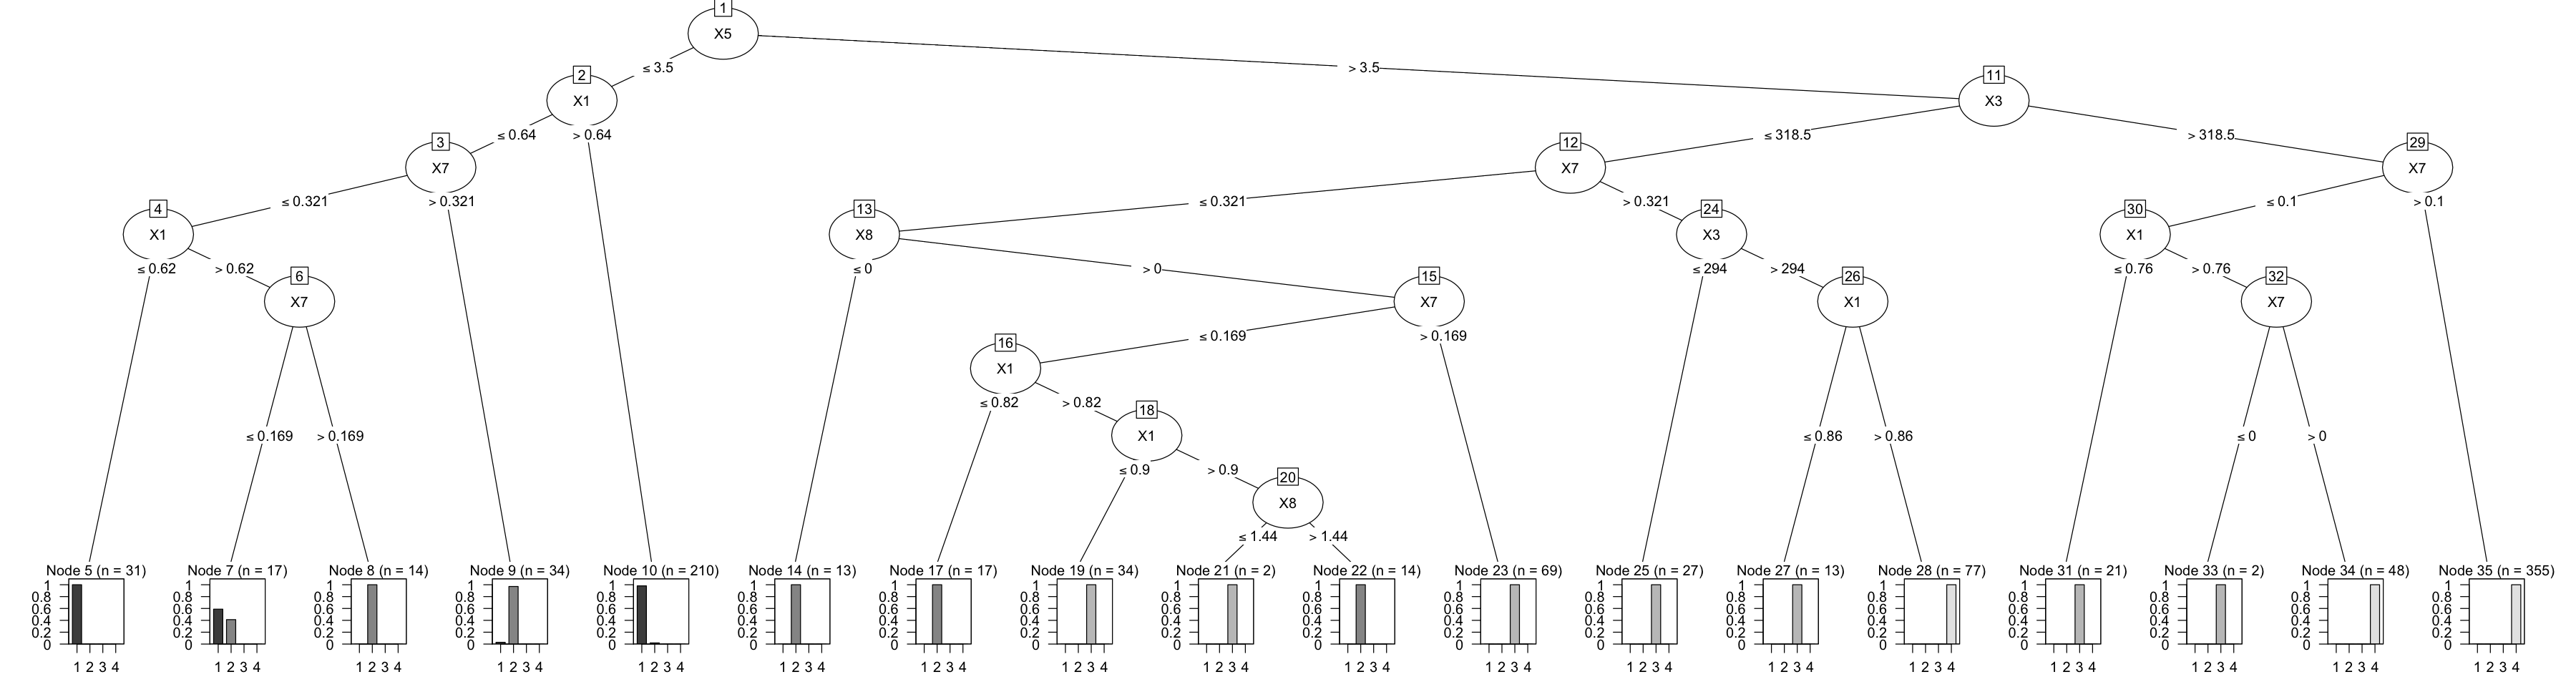

In [220]:
options(repr.plot.width=30, repr.plot.height=8)
plot( data_balanced.tree_reduced )

In [221]:
conf.matrix.tree_reduced <- confusionMatrix(table( data_balanced_test.set$Y1_group, tree.pred.class ))
print( conf.matrix.tree_reduced )

Confusion Matrix and Statistics

   tree.pred.class
      1   2   3   4
  1  57   4   0   0
  2   2  23   0   0
  3   0   0  42   0
  4   0   0   0 120

Overall Statistics
                                          
               Accuracy : 0.9758          
                 95% CI : (0.9481, 0.9911)
    No Information Rate : 0.4839          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9638          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9661  0.85185   1.0000   1.0000
Specificity            0.9788  0.99095   1.0000   1.0000
Pos Pred Value         0.9344  0.92000   1.0000   1.0000
Neg Pred Value         0.9893  0.98206   1.0000   1.0000
Prevalence             0.2379  0.10887   0.1694   0.4839
Detection Rate         0.2298  0.09274   0.1694   0.4839
Detection Prevalenc

El modelo muestra un rendimiento muy alto con una precisión global del 97.58% y un valor de Kappa de 0.9638, indicando una excelente concordancia entre las predicciones del modelo y las clases reales. Las sensibilidades y especificidades son muy altas para todas las clases, especialmente para las Clases 3 y 4, que tienen valores perfectos del 100%. Las Clases 1 y 2 también muestran buenos resultados, aunque la Clase 2 tiene una sensibilidad ligeramente menor (85.19%) comparada con las demás. En general, el modelo proporciona una clasificación precisa y confiable, con muy pocos errores en la predicción de las clases.